### Setup

In [17]:
# Import necessary libraries
import pyroaring as pr
import duckdb
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from snomed_characterization.condition_cluster_analyzer  import ConditionClusterAnalyzer

In [3]:
# Define file paths for all the CSVs
files = {
    "concept": "data/vocabulary/CONCEPT.csv",
    "concept_ancestor": "data/vocabulary/CONCEPT_ANCESTOR.csv",
    "concept_class": "data/vocabulary/CONCEPT_CLASS.csv",
    "concept_relationship": "data/vocabulary/CONCEPT_RELATIONSHIP.csv",
    "concept_synonym": "data/vocabulary/CONCEPT_SYNONYM.csv",
    "domain": "data/vocabulary/DOMAIN.csv",
    "drug_strength": "data/vocabulary/DRUG_STRENGTH.csv",
    "relationship": "data/vocabulary/RELATIONSHIP.csv",
    "vocabulary": "data/vocabulary/VOCABULARY.csv",
}

# Create and connect to the target DuckDB
target_con = duckdb.connect("data/full_data.duckdb")

# Load each CSV file into the DuckDB as a table
for table_name, file_path in files.items():
    query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} AS 
    SELECT * FROM read_csv_auto('{file_path}', ignore_errors=true, quote='\"');
    """
    target_con.execute(query)
    print(f"Table {table_name} created and populated (with errors ignored).")

# Example: Populate additional patient-related data from another DuckDB
source_con = duckdb.connect("data/my_sampled_cdm.duckdb", read_only=True)

tables_to_transfer = [
    "person",
    "condition_era",
    "condition_occurrence",
    "death",
    "observation_period",
]

for table in tables_to_transfer:
    df = source_con.execute(f"SELECT * FROM {table}").fetchdf()
    target_con.register(f"{table}_df", df)
    query = f"CREATE TABLE IF NOT EXISTS {table} AS SELECT * FROM {table}_df;"
    target_con.execute(query)
    print(f"Table {table} created and populated.")

# Close connections
source_con.close()
target_con.close()
print("All tables successfully created and populated.")

Table concept created and populated (with errors ignored).
Table concept_ancestor created and populated (with errors ignored).
Table concept_class created and populated (with errors ignored).
Table concept_relationship created and populated (with errors ignored).
Table concept_synonym created and populated (with errors ignored).
Table domain created and populated (with errors ignored).
Table drug_strength created and populated (with errors ignored).
Table relationship created and populated (with errors ignored).
Table vocabulary created and populated (with errors ignored).
Table person created and populated.
Table condition_era created and populated.
Table condition_occurrence created and populated.
Table death created and populated.
Table observation_period created and populated.
All tables successfully created and populated.


### Implementation

In [11]:
def get_patient_conditions_bitmap(conn: duckdb.DuckDBPyConnection):
    query = """
    WITH condition_arrays AS (
      SELECT 
        CAST(person_id AS INTEGER) AS person_id,
        array_agg(DISTINCT CAST(condition_concept_id AS INTEGER)) as condition_ids
      FROM condition_occurrence
      WHERE 
        condition_concept_id != 0  -- exclude unmapped
        AND condition_start_date IS NOT NULL
      GROUP BY person_id
    )
    SELECT condition_ids FROM condition_arrays
    """
    results = conn.execute(query).fetchall()
    return [pr.BitMap(condition_list) for condition_list, in results]

In [12]:
conn = duckdb.connect("data/full_data.duckdb")

try:
    patient_conditions = get_patient_conditions_bitmap(conn)
    print(f"Number of patients processed: {len(patient_conditions)}")
    print("Sample bitmap (first patient):", list(patient_conditions[0]))
except Exception as e:
    print("Error in get_patient_conditions_bitmap:", e)

conn.close()


Number of patients processed: 9751
Sample bitmap (first patient): [194133, 320128, 4088609, 40400344]


In [18]:
def load_snomed_graph(conn: duckdb.DuckDBPyConnection):
    query = """
    SELECT ancestor_concept_id, descendant_concept_id
    FROM concept_ancestor
    """
    results = conn.execute(query).fetchall()

    graph = nx.DiGraph()
    graph.add_edges_from(results)
    return graph

def visualize_snomed_graph(graph, title="SNOMED Graph", node_limit=100):
    if len(graph.nodes) > node_limit:
        subgraph = graph.subgraph(list(graph.nodes)[:node_limit])
    else:
        subgraph = graph

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph)
    nx.draw(
        subgraph, pos, node_size=50, node_color="blue", edge_color="gray", with_labels=False
    )
    plt.title(title)
    plt.show()

### Validation

SNOMED graph loaded with 547516 nodes and 7831907 edges.


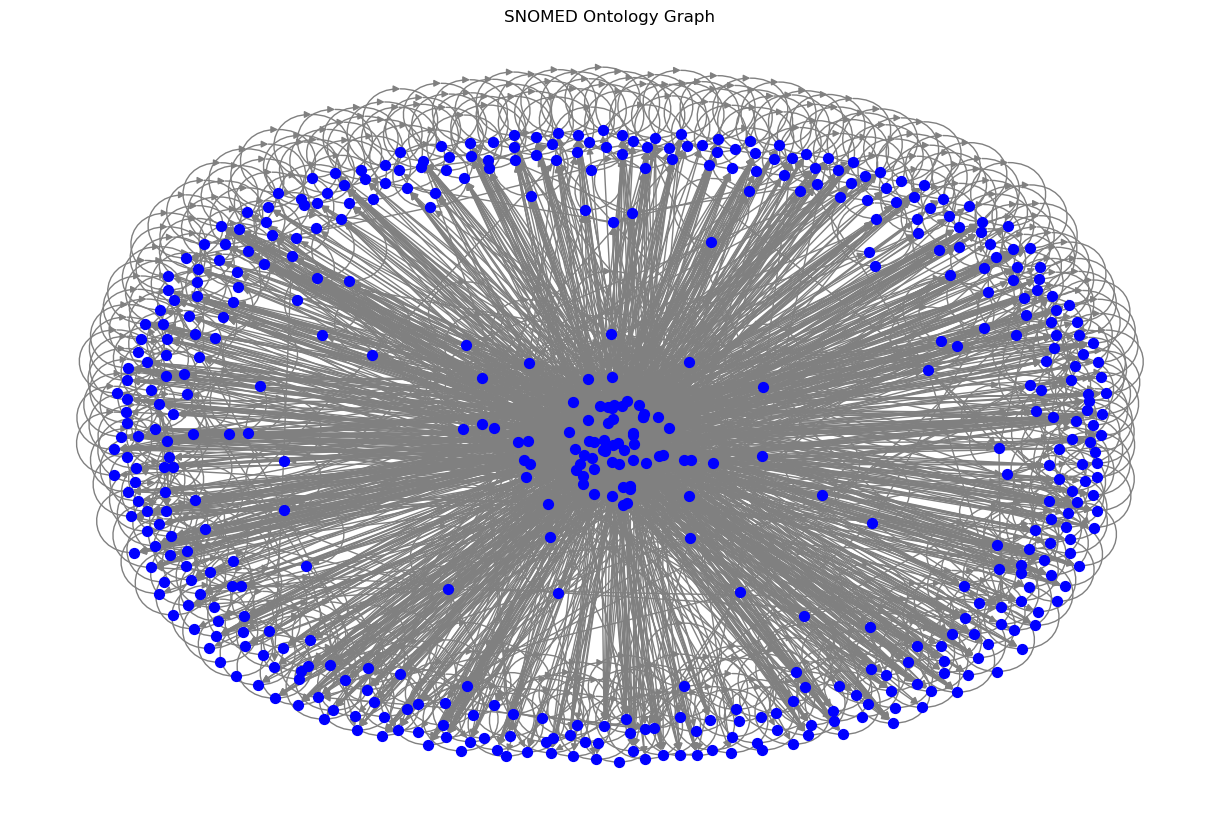

Cluster Metrics: {'modularity': 0.09487004221268788, 'num_communities': 2, 'avg_community_size': 50.0, 'min_community_size': 45, 'max_community_size': 55}
Enriched Clusters: defaultdict(<class 'set'>, {0: {443392, 4167693, 4103183, 4103184, 4304916, 4103189, 4103192, 373785, 4184090, 44782620, 30753, 4280354, 4130852, 4054054, 4093991, 4217894, 4089897, 443432, 4176946, 440371, 321588, 4184117, 37018677, 4260918, 4186164, 137275, 4287548, 37168189, 4132926, 4181063, 4181064, 31821, 4201554, 4002898, 4042836, 440409, 201820, 4101212, 193631, 439392, 201826, 4185186, 4028528, 73842, 196724, 4115574, 73847, 4115576, 374905, 4020346, 4198525, 196734, 196738, 4305027, 75909, 77960, 4087949, 4182161, 4208786, 4063381, 4182165, 372887, 198809, 4308125, 4297887, 4027553, 4162723, 4114604, 4022449, 4227252, 4227253, 4244662, 199860, 37311677, 37311678, 4182210, 4309188, 4179141, 4181190, 4180169, 4181194, 4354249, 4266186, 4170962, 4113619, 4181204, 37206233, 138239, 77030, 4024552, 373995, 442

In [19]:
def validate_roaring_bitmap_workflow():
    db_path = "data/full_data.duckdb"
    conn = duckdb.connect(db_path, read_only=True)

    # Load patient conditions as Roaring Bitmaps
    patient_conditions = get_patient_conditions_bitmap(conn)

    # Load the SNOMED graph
    snomed_graph = load_snomed_graph(conn)
    print(f"SNOMED graph loaded with {snomed_graph.number_of_nodes()} nodes and {snomed_graph.number_of_edges()} edges.")
    conn.close()

    # Visualize the SNOMED graph
    visualize_snomed_graph(snomed_graph, title="SNOMED Ontology Graph", node_limit=500)

    # Initialize the ConditionClusterAnalyzer
    analyzer = ConditionClusterAnalyzer(snomed_graph)

    # Build the co-occurrence network
    analyzer.build_cooccurrence_network(patient_conditions)

    # Detect clusters using Greedy Modularity
    communities = analyzer.detect_clusters(method="greedy_modularity")

    # Compute metrics for the clusters
    metrics = analyzer.get_cluster_metrics(communities)
    print("Cluster Metrics:", metrics)

    # Enrich clusters with SNOMED hierarchy
    enriched_clusters = analyzer.enrich_clusters_with_snomed(communities)
    print("Enriched Clusters:", enriched_clusters)

# Run the validation workflow
validate_roaring_bitmap_workflow()